In [74]:
import os
import sys
import pandas as pd
import seaborn as sns

# Results grid analysis notebook

Running the trials and experiments via Ray produces a number of files that are related to the "experiment" (dataset and all the strategies + all the repeated runs, each being a "trial"). Each trial is stored individually, but will be read and collected by a `result_grid` object that can be used to analyse results at the experiment and trial level.

This notebook is intended to be used for all the experiments, adapt as necessary to produce the relevant plots.

In [75]:
# Load result_grid
# Adapt as needed
from ray import tune
experiment_name = "diabetes"
storage_path = os.path.join(os.getcwd(), f"ray_benchmark_results")
experiment_path = os.path.join(storage_path, experiment_name)

print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable="trial")
result_grid = restored_tuner.get_results()
print(f"Type of result_grid: {type(result_grid)}")


Loading results from /Users/rlps281/workspace/pyrelational/benchmarking/ray_benchmark_results/diabetes...
Type of result_grid: <class 'ray.tune.result_grid.ResultGrid'>


In [76]:
# First we will do some housekeeping to make sure our results grid is as we expect

# Check if there have been errors
if result_grid.errors:
    print("One of the trials failed!")
else:
    print("No errors!")

num_results = len(result_grid)
print("Number of results:", num_results)

# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a test metric of: {result.metrics["score"]}"
    )

No errors!
Number of results: 35
Trial #0 finished successfully with a test metric of: 7078539.823734714
Trial #1 finished successfully with a test metric of: 16895586.2356885
Trial #2 finished successfully with a test metric of: 18810200.95678287
Trial #3 finished successfully with a test metric of: 19513126.934539475
Trial #4 finished successfully with a test metric of: 5031828.290913744
Trial #5 finished successfully with a test metric of: 33997193.85339594
Trial #6 finished successfully with a test metric of: 13704778.221300296
Trial #7 finished successfully with a test metric of: 20756783.60285862
Trial #8 finished successfully with a test metric of: 8877698.386491632
Trial #9 finished successfully with a test metric of: 6615796.69099113
Trial #10 finished successfully with a test metric of: 16514914.462485733
Trial #11 finished successfully with a test metric of: 9783894.606440363
Trial #12 finished successfully with a test metric of: 14077617.522716573
Trial #13 finished success

In [77]:
results_df = result_grid.get_dataframe()

In [78]:
results_df

,score,iteration_metrics,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/seed,config/strategy,logdir
0,7.078540e+06,"[7462.7180051997975, 6352.960985621885, 5779.7...",1727802263,None,False,1,e905d_00026,2024-10-01_18-04-23,2.073112,2.073112,13432,mba-rlps281,127.0.0.1,2.073112,1,2,variance_reduction,e905d_00026
1,1.689559e+07,"[9743.396227496383, 12296.407426090198, 11579....",1727802236,None,False,1,e905d_00019,2024-10-01_18-03-56,3.148794,3.148794,13418,mba-rlps281,127.0.0.1,3.148794,1,5,thompson_sampling,e905d_00019
2,1.881020e+07,"[16949.55331308638, 6767.698195816851, 6596.12...",1727802175,None,False,1,e905d_00007,2024-10-01_18-02-55,3.498235,3.498235,13370,mba-rlps281,127.0.0.1,3.498235,1,3,expected_improvement,e905d_00007
3,1.951313e+07,"[21189.009739049074, 18710.560436977717, 10397...",1727802216,None,False,1,e905d_00015,2024-10-01_18-03-36,3.835645,3.835645,13394,mba-rlps281,127.0.0.1,3.835645,1,1,thompson_sampling,e905d_00015
4,5.031828e+06,"[21189.009739049074, 17152.31550415724, 8313.9...",1727802259,None,False,1,e905d_00025,2024-10-01_18-04-19,2.228845,2.228845,13431,mba-rlps281,127.0.0.1,2.228845,1,1,variance_reduction,e905d_00025
5,3.399719e+07,"[9743.396227496383, 12827.929340251805, 18150....",1727802212,None,False,1,e905d_00014,2024-10-01_18-03-32,4.144346,4.144346,13393,mba-rlps281,127.0.0.1,4.144346,1,5,greedy,e905d_00014
6,1.370478e+07,"[9743.396227496383, 12827.929340251805, 18150....",1727802184,None,False,1,e905d_00009,2024-10-01_18-03-04,3.766877,3.766877,13374,mba-rlps281,127.0.0.1,3.766877,1,5,expected_improvement,e905d_00009
7,2.075678e+07,"[16949.55331308638, 13582.482908757227, 7156.6...",1727802226,None,False,1,e905d_00017,2024-10-01_18-03-46,4.050587,4.050587,13407,mba-rlps281,127.0.0.1,4.050587,1,3,thompson_sampling,e905d_00017
8,8.877698e+06,"[7462.7180051997975, 6352.960985621885, 5779.7...",1727802144,None,False,1,e905d_00001,2024-10-01_18-02-24,3.485177,3.485177,13327,mba-rlps281,127.0.0.1,3.485177,1,2,bald,e905d_00001
9,6.615797e+06,"[12661.617035255482, 12019.624643993886, 9296....",1727802154,None,False,1,e905d_00003,2024-10-01_18-02-34,3.605168,3.605168,13344,mba-rlps281,127.0.0.1,3.605168,1,4,bald,e905d_00003


In [79]:
from tqdm import tqdm
def process_results_grid_into_sns_plot_df(results_df):
    """Process the results grid into a data frame so that we can plot line plots with seaborn.

    The current results_df format has each row as a trial, with columns for the trial's parameters and metrics.
    We want to create a data frame that has a row for each trial and each element in the list of iteration_metrics,
    such that we can plot the metrics over the iterations. The resulting data frame will have the following columns:

    - trial_id: The trial's ID
    - iteration: The iteration number
    - test_metric: The test metric at that iteration
    - strategy: The strategy used in that iteration
    - seed: The seed used in that trial
    - score: The score for that trial
    """

    # iteration_metrics = ["test_metric"] # if it was a dictionary entry in the row
    sns_plot_df = []

    for a, row in tqdm(results_df.iterrows()):
        trial_id = row["trial_id"]
        seed = row["config/seed"]
        score = row["score"]

        for iteration, metric_value in enumerate(row["iteration_metrics"]):
            # for metric_val in iteration_metrics:
            sns_plot_df.append(
                {
                    "trial_id": trial_id,
                    "iteration": iteration,
                    "test_metric": metric_value,
                    "strategy": row["config/strategy"],
                    "seed": seed,
                    "score": score,
                }
            )

    return pd.DataFrame(sns_plot_df)

In [80]:
sns_results_df = process_results_grid_into_sns_plot_df(results_df)
sns_results_df

0it [00:00, ?it/s]

35it [00:00, 3149.76it/s]


,trial_id,iteration,test_metric,strategy,seed,score
0,e905d_00026,0,7462.718005,variance_reduction,2,7.078540e+06
1,e905d_00026,1,6352.960986,variance_reduction,2,7.078540e+06
2,e905d_00026,2,5779.720216,variance_reduction,2,7.078540e+06
3,e905d_00026,3,9715.392003,variance_reduction,2,7.078540e+06
4,e905d_00026,4,9540.353605,variance_reduction,2,7.078540e+06
...,...,...,...,...,...,...
10180,e905d_00027,286,67880.941497,variance_reduction,3,7.362446e+06
10181,e905d_00027,287,79360.643647,variance_reduction,3,7.362446e+06
10182,e905d_00027,288,79441.083591,variance_reduction,3,7.362446e+06
10183,e905d_00027,289,76517.684557,variance_reduction,3,7.362446e+06


<Axes: xlabel='iteration', ylabel='test_metric'>

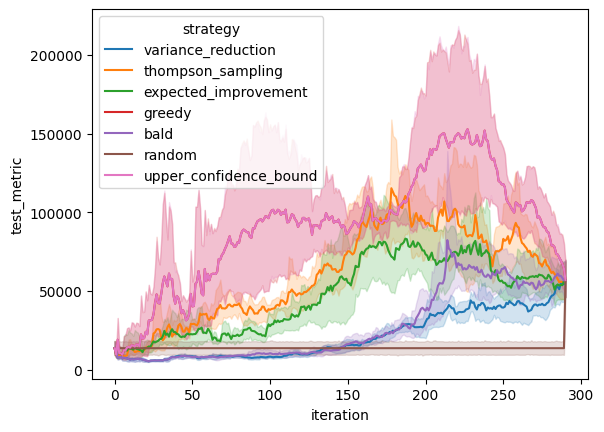

In [81]:
sns.lineplot(data=sns_results_df, x="iteration", y="test_metric", hue="strategy")